### Предобработка датасета

**Загрузка данных**

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')

from nltk.util import ngrams
from nltk import word_tokenize 

# !pip install wordcloud
# !pip install --upgrade Pillow
from wordcloud import WordCloud

In [2]:
%%time
df = pd.DataFrame(
    pd.read_csv(
        'train_150k.txt', 
        sep='\t', 
        header=None
    ).values, 
    columns=['target', 'text']
).iloc[:, [1, 0]]

CPU times: user 140 ms, sys: 13.7 ms, total: 153 ms
Wall time: 157 ms


**Первичный осмотр данных**

Проверка размера датасета

In [3]:
df.shape

(149985, 2)

Просмотр первых нескольких записей

In [4]:
df.head(5)

,text,target
0,Starting back at work today Looks like it'l...,0
1,Sugar levels dropping... munchies setting in. ...,1
2,@karineb22 yeah!!! have a great summer break!,1
3,hannah montana was very good. now going to re...,1
4,"@Mayra326 aww, have fun! I just had my 3D las...",1


Проверка типов данных и отсутствующих значений

In [5]:
df.dtypes

text      object
target    object
dtype: object

In [6]:
df.isna().any()

text      False
target    False
dtype: bool

TODO. Потом убрать -- проверка проблем. До предобработки:

In [7]:
df.loc[df.text.str.contains('\w*nna\s'), 'text']

36        isn't a fan of the hot hot weather.  about to ...
39                    But we don't know what were gonna do 
54        anyone out there speak mandarin, wanna maybe c...
168       @Snythare reciving the hug  I don't wanna be i...
211       dinner was gr8..nw wnt to multi-game bt no bro...
                                ...                        
149896    @Jorge924 i know this!  lol leaving back tomor...
149906    My body doesn't feel good... Feels like I'm go...
149922    Ironing - done, Painting - complete, Washing -...
149938    I wanna go home,but I don't wanna go to work  ...
149961    @danecook i wanna go to your show in new orlea...
Name: text, Length: 3882, dtype: object

После:

**Анализ целевой переменной**

Подсчет и визуализация распределения положительных и отрицательных твитов

([<matplotlib.patches.Wedge at 0x7fec62344730>,
 [Text(-0.0006105213261774311, 1.0999998305744008, 'Негативный класс'),
  Text(0.0006104183367606855, -1.099999830631557, 'Позитивный класс')],
 [Text(-0.0003330116324604169, 0.5999999075860367, '50.0%'),
  Text(0.00033295545641491927, -0.5999999076172129, '50.0%')])

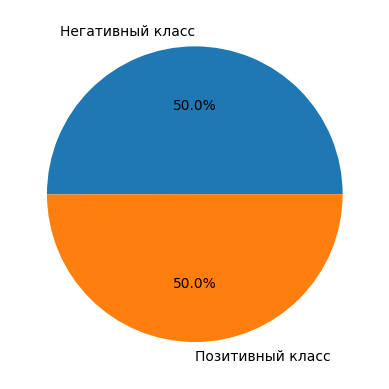

In [9]:
plt.pie([(1 - df.target).sum(), df.target.sum()], labels=['Негативный класс', 'Позитивный класс'], autopct='%1.1f%%')

**Предобработка текста**

In [63]:
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"  # TODO: позже очищу от них текст -- хештеги, @username, !!?! etc. 

pattern1 = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
pattern2 = r'@([A-Za-z0-9_]{1,})'
pattern3 = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
pattern4 = r'<[^>]+>'
pattern5 = r'#\w+'  # ноутбук Лизы
pattern6 = r'''[!#*\-''"]+'''  # TODO пунктуация

patterns = '|'.join([f'({pattern1})', f'({pattern2})', f'({pattern3})', f'({pattern4})', f'({pattern5})', f'({pattern6})'])

stopwords_en = stopwords.words("english")
morph = MorphAnalyzer()

Токенизация

In [64]:
df = df.assign(tokens = df.text.str.replace(patterns, '', regex=True).str.split())

Удаление стоп-слов

In [65]:
%%time
df.tokens = df.tokens.apply(lambda tokens_list : list(filter(lambda x : x not in stopwords_en, tokens_list)))

CPU times: user 3.13 s, sys: 11.2 ms, total: 3.14 s
Wall time: 3.14 s


Лемматизация

In [66]:
%%time
df.tokens = df.tokens.apply(lambda tokens_list : list(map(lambda token : morph.normal_forms(token)[0], tokens_list)))

CPU times: user 15.9 s, sys: 63.6 ms, total: 16 s
Wall time: 16 s


In [67]:
df = df.assign(words = df.tokens.apply(lambda x : ' '.join(x)))

**Анализ текстовых данных**

Распределение длины твитов (количество символов и слов)

In [68]:
symbols_cnt = df.words.str.len() 
words_cnt = df.words.str.count(' ') + 1

Text(0.5, 1.0, 'words hist')

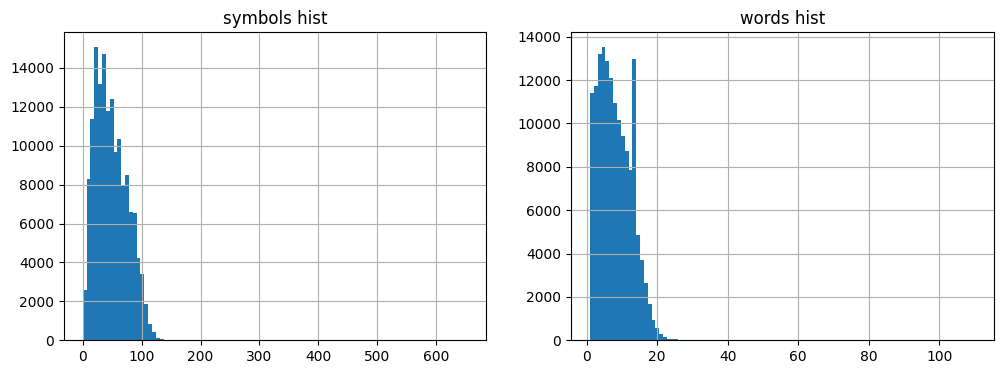

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

symbols_cnt.hist(ax=axs[0], bins=100)
words_cnt.hist(ax=axs[1], bins=100)

axs[0].set_title('symbols hist')
axs[1].set_title('words hist')

Частота слов: топ-20 самых частых слов для каждой тональности

In [70]:
def find_top_words(df, target_val):
    words_list = ' '.join(df.loc[df.target == target_val, 'words'].values.tolist()).split()

    word_cnt = Counter(words_list)
    top20_cnt = sorted(word_cnt.values())[-20:]

    top_cnt_words = [w for w in word_cnt if word_cnt[w] in top20_cnt]
    print(top_cnt_words)

In [71]:
find_top_words(df, 0)

['back', 'work', 'today', 'like', 'still', 'one', 'get', 'im', 'i', 'really', 'good', 'want', 'going', "i'm", 'miss', 'got', 'day', 'go', 'know', "can't"]


In [72]:
find_top_words(df, 1)

['i', 'great', 'going', 'got', "i'm", 'day', 'good', 'lol', 'time', 'u', 'go', 'thanks', 'know', 'like', 'back', 'get', 'love', 'see', 'new', 'one']


Облака слов для положительных и отрицательных твитов

In [73]:
all_words = ' '.join(df.loc[df.target == 1, 'words'].values.tolist())

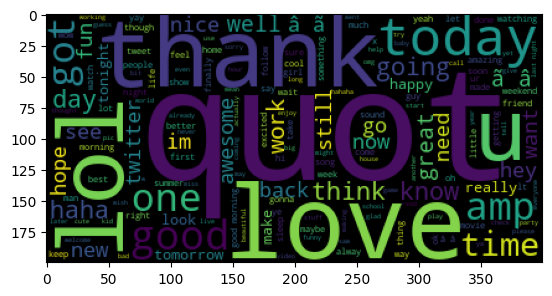

CPU times: user 2.64 s, sys: 48.8 ms, total: 2.69 s
Wall time: 2.7 s


In [74]:
%%time
plt.imshow(WordCloud().generate(all_words))
plt.show()

In [75]:
all_words = ' '.join(df.loc[df.target == 0, 'words'].values.tolist())

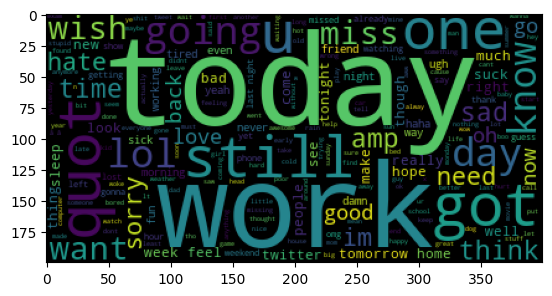

CPU times: user 2.7 s, sys: 52.2 ms, total: 2.75 s
Wall time: 2.76 s


In [76]:
%%time
plt.imshow(WordCloud().generate(all_words))
plt.show()

**Анализ n-грамм**

Визуализация топ-20 биграмм и триграмм для каждой тональности

In [77]:
df['bigrams'] = df.tokens.apply(lambda tokens_list : list(list(ngrams(tokens_list, 2))))

In [78]:
def find_top_ngrams(df, ngrams_col):
    words_list = []
    for w in df[ngrams_col].values.tolist():
        words_list += w

    word_cnt = Counter(words_list)
    top20_cnt = sorted(word_cnt.values())[-20:]

    top_cnt_words = [w for w in word_cnt if word_cnt[w] in top20_cnt]
    return {w: word_cnt[w] for w in top_cnt_words}

([<matplotlib.axis.XTick at 0x7fec374cfbb0>,
 [Text(0, 0, "i'm going"),
  Text(1, 0, 'i miss'),
  Text(2, 0, 'i really'),
  Text(3, 0, 'i think'),
  Text(4, 0, 'i need'),
  Text(5, 0, 'i got'),
  Text(6, 0, 'i wish'),
  Text(7, 0, 'good morning'),
  Text(8, 0, "i can't"),
  Text(9, 0, "can't wait"),
  Text(10, 0, 'wish i'),
  Text(11, 0, 'i know'),
  Text(12, 0, 'i love'),
  Text(13, 0, 'i want'),
  Text(14, 0, 'i hope'),
  Text(15, 0, 'i could'),
  Text(16, 0, 'last night'),
  Text(17, 0, 'i feel'),
  Text(18, 0, 'i hate'),
  Text(19, 0, 'i get')])

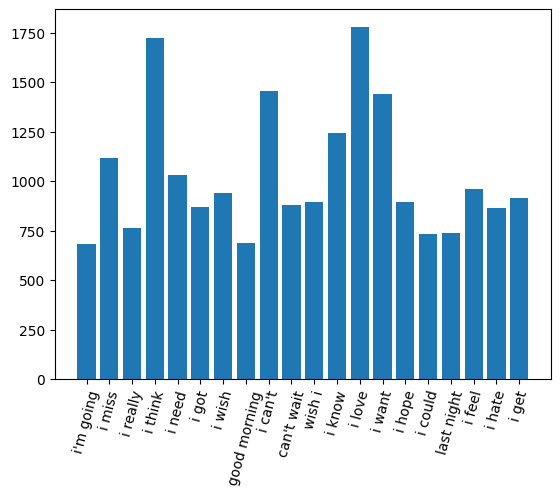

In [81]:
# TODO: optimize several function calls as in the 3grams section
plt.bar(
    range(len(list(find_top_ngrams(df, 'bigrams').values()))),
    list(find_top_ngrams(df, 'bigrams').values()), 
    label=list(map(lambda x : ' '.join(x), find_top_ngrams(df, 'bigrams').keys()))
)
plt.xticks(
    range(len(list(find_top_ngrams(df, 'bigrams').values()))), 
    list(map(lambda x : ' '.join(x), find_top_ngrams(df, 'bigrams').keys())),
    rotation=75
)

In [82]:
df['trigrams'] = df.tokens.apply(lambda tokens_list : list(list(ngrams(tokens_list, 3))))

([<matplotlib.axis.XTick at 0x7febf0bbff70>,
 [Text(0, 0, "i can't wait"),
  Text(1, 0, "can't wait see"),
  Text(2, 0, 'i think i'),
  Text(3, 0, 'i wanna go'),
  Text(4, 0, '. . .'),
  Text(5, 0, 'i wish i'),
  Text(6, 0, 'wish i could'),
  Text(7, 0, "i think i'm"),
  Text(8, 0, 'i know i'),
  Text(9, 0, 'i feel like'),
  Text(10, 0, 'i want go'),
  Text(11, 0, 'get 100 followers'),
  Text(12, 0, '100 followers day'),
  Text(13, 0, 'followers day using'),
  Text(14, 0, 'day using once'),
  Text(15, 0, 'using once add'),
  Text(16, 0, 'once add everyone'),
  Text(17, 0, 'add everyone train'),
  Text(18, 0, 'everyone train pay'),
  Text(19, 0, 'train pay vip')])

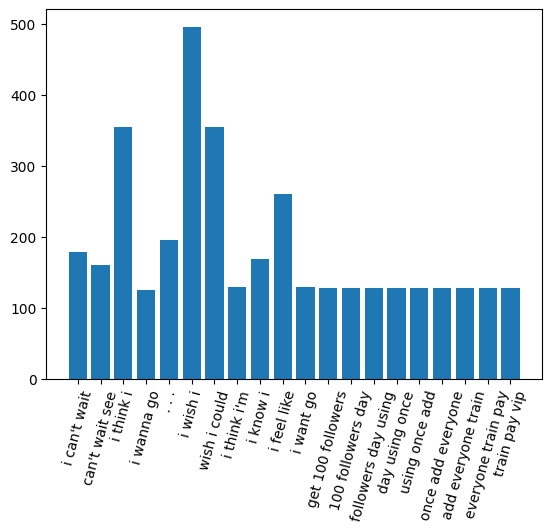

In [83]:
top_trigrams = find_top_ngrams(df, 'trigrams')
plt.bar(
    range(len(list(top_trigrams.values()))),
    list(top_trigrams.values()), 
    label=list(map(lambda x : ' '.join(x), top_trigrams.keys()))
)
plt.xticks(
    range(len(list(top_trigrams.values()))), 
    list(map(lambda x : ' '.join(x), top_trigrams.keys())),
    rotation=75
)

**t-SNE**

In [84]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

In [86]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(df.text).toarray()

In [87]:
%%time

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(tfidf_matrix)

CPU times: user 1h 8min 42s, sys: 9min 34s, total: 1h 18min 17s
Wall time: 14min 52s


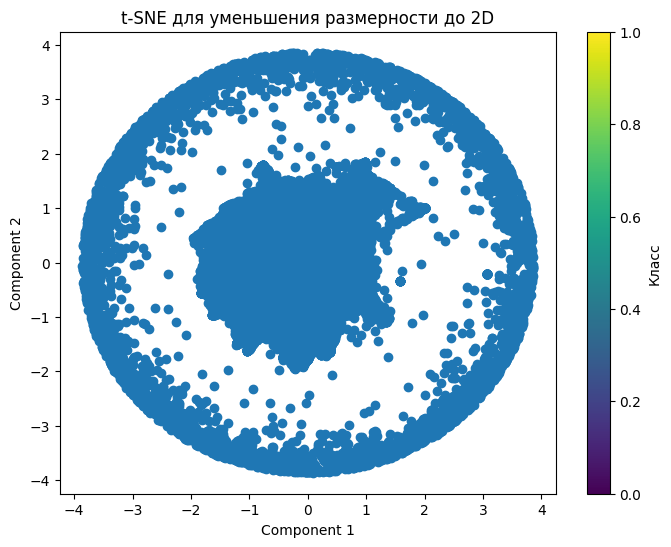

In [88]:
tsne_df = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])

# Визуализация результата
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'])
plt.colorbar(label='Класс')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE для уменьшения размерности до 2D')
plt.show()